In [234]:
#importing libraries
from glob import glob
import re
import string
import funcy as fp

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

#nltk for stopwords
import nltk
from nltk.corpus import stopwords

#general libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#----------------------------------------

from tqdm import tqdm

tqdm.pandas()

/usr/local/Cellar/jupyterlab/2.1.2/libexec/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [171]:
import pickle #saving our model and LDA 

In [172]:
#importing pyLDavis library and visualization keys
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

## Loading Dataset

In [173]:
train_news = pd.read_csv('data/clean_news.csv', index_col = False )

In [175]:
train_news.drop(['Unnamed: 0',], axis = 1)

,author,title,text,label
0,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Daniel J. Flynn,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Consortiumnews.com,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,Jessica Purkiss,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Howard Portnoy,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...
19343,Jerome Hudson,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0
19344,Benjamin Hoffman,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0
19345,Michael J. de la Merced and Rachel Abrams,Macy’s Is Said to Receive Takeover Approach by...,The Macy’s of today grew from the union of sev...,0
19346,Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...","NATO, Russia To Hold Parallel Exercises In Bal...",1


## Cleaning our articles and titles 

In [176]:
#defining variables for punctuation and stop words 
    punct = string.punctuation
    stopwords = list(STOP_WORDS)
    stopwords.append(['·','»','«','–','...','--'])
    
    #declaring the spacy model name we are going to be using and loading it
    spacy_model_name = 'en_core_web_sm'

    #if not spacy.util.is_package(spacy_model_name):
        #spacy.cli.download(spacy_model_name)
    nlp = spacy.load(spacy_model_name)
    
    
#cleaning text function (try to import it instead!)
def cleaning_news(article):
    
    doc = nlp(article)
    
    #turning the articles into tokens and lowering the case and lemmatizing them
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    
    #storing clean tokens which aren't stopwords in a list.
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and token not in punct:
            cleaned_tokens.append(token)
            
    #double cleaning tokens to eliminate any trace of punctuation and signs:
    pat = r'[^a-zA-z.,!?/:;\"\'\s]'
    cleantokens = cleaned_tokens.copy()
    for word in cleaned_tokens:
        word = re.sub(pat, '', word)
        cleantokens.append(word)
        for word in cleantokens: 
            if word == '':
                cleantokens.remove('')
                

    return cleantokens

### Applying the cleaning function to our title and text columns

In [182]:
title_cleaned_1 = train_news.title[0:5000].progress_apply(cleaning_news)

100%|██████████| 5000/5000 [1:01:28<00:00,  1.36it/s]


In [183]:
title_cleaned_2 = train_news.title[5001:10000].progress_apply(cleaning_news)

100%|██████████| 4999/4999 [1:01:39<00:00,  1.35it/s]


In [184]:
title_cleaned_3 = train_news.title[10001:15000].progress_apply(cleaning_news)

100%|██████████| 4999/4999 [1:01:57<00:00,  1.34it/s]


In [185]:
title_cleaned_4 = train_news.title[15001:19349].progress_apply(cleaning_news)

100%|██████████| 4347/4347 [54:05<00:00,  1.34it/s]


In [178]:
text_cleaned_1 = train_news.text[0:5000].progress_apply(cleaning_news)

100%|██████████| 5000/5000 [1:04:59<00:00,  1.28it/s]


In [179]:
text_cleaned_2 = train_news.text[5001:10000].progress_apply(cleaning_news)

100%|██████████| 4999/4999 [1:08:09<00:00,  1.22it/s]


In [180]:
text_cleaned_3 = train_news.text[10001:15000].progress_apply(cleaning_news)

100%|██████████| 4999/4999 [1:10:47<00:00,  1.18it/s]


In [181]:
text_cleaned_4 = train_news.text[15001:19349].progress_apply(cleaning_news)

100%|██████████| 4347/4347 [1:03:45<00:00,  1.14it/s]


### Saving our cleaned columns to pickles to re-use them later at our modeling

In [195]:
#merging all the column together

text_clean = text_cleaned_1.append([text_cleaned_2, text_cleaned_3, text_cleaned_4], ignore_index=True)
title_clean = title_cleaned_1.append([title_cleaned_2, title_cleaned_3, title_cleaned_4], ignore_index=True)

In [196]:
# saving cleaned text articles to pickle
text_clean.to_pickle('./data/cleaned_text.pkl')
title_clean.to_pickle('./data/cleaned_title.pkl')

#saving a slice for lighter training
text_cleaned_1.to_pickle('./data/cleaned_text_1.pkl')
title_cleaned_1.to_pickle('./data/cleaned_title_1.pkl')


## Topic Modeling with our text or articles variable

In [197]:
#creating a corpus dictionary with token count
id2word = corpora.Dictionary(text_clean) 

texts = text_clean

corpus = [id2word.doc2bow(text) for text in texts] 

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]] 

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True) 

# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus] 

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=text_clean, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.053*"mr." + 0.028*"trump" + 0.013*"president" + 0.008*"house" + 0.007*"obama" + 0.006*"administration" + 0.006*"republican" + 0.006*"state" + 0.005*"new" + 0.005*"—"'), (1, '0.014*"company" + 0.012*"year" + 0.010*"percent" + 0.009*"million" + 0.008*"new" + 0.007*"pay" + 0.006*"money" + 0.006*"market" + 0.006*"business" + 0.005*"work"'), (2, '0.026*"trump" + 0.023*"clinton" + 0.012*"hillary" + 0.012*"election" + 0.009*"campaign" + 0.008*"news" + 0.007*"email" + 0.007*"vote" + 0.007*"donald" + 0.007*"people"'), (3, '0.009*"like" + 0.007*"—" + 0.007*"’" + 0.007*"year" + 0.007*"time" + 0.007*"new" + 0.006*"ms." + 0.005*"good" + 0.005*"day" + 0.005*"know"'), (4, '0.013*"russia" + 0.011*"war" + 0.011*"country" + 0.010*"world" + 0.009*"government" + 0.008*"russian" + 0.007*"united" + 0.006*"american" + 0.006*"states" + 0.006*"power"'), (5, '0.009*"people" + 0.009*"use" + 0.007*"dr." + 0.006*"life" + 0.005*"human" + 0.005*"health" + 0.005*"study" + 0.005*"find" + 0.005*"need" + 0.005*"

In [198]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics) 

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [199]:
coherence_values

[0.3013170299545198,
 0.3406781048976093,
 0.32991702259372996,
 0.3247583636548433,
 0.333262972009578,
 0.3479351446082483,
 0.3329274249757472]

In [213]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=text_clean, limit=45, start=2, step=6)

In [214]:
x = range(start, limit, step)
x

range(2, 40, 6)

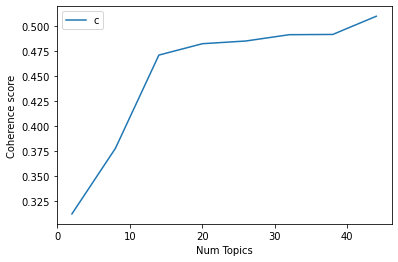

In [216]:
# Show graph
limit=45; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [223]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

print('\nPerplexity: ', lda_model.log_perplexity(corpus))

Num Topics = 2  has Coherence Value of 0.3121
Num Topics = 8  has Coherence Value of 0.3776
Num Topics = 14  has Coherence Value of 0.4709
Num Topics = 20  has Coherence Value of 0.4822
Num Topics = 26  has Coherence Value of 0.485
Num Topics = 32  has Coherence Value of 0.4913
Num Topics = 38  has Coherence Value of 0.4915
Num Topics = 44  has Coherence Value of 0.5097

Perplexity:  -13.91913150720254


In [224]:
model_list

In [253]:
#saving lda best performing model
optimal_model.save('lda.model')

In [225]:
#redefining the LDA model based on the coherence values

optimal_model = model_list[7] # change here the index of the optimal model
model_topics = optimal_model.show_topics(formatted=False)

In [226]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.017395  0.035544       1        1  7.797940
25     0.040032  0.150325       2        1  7.333564
17    -0.145786  0.098092       3        1  5.622528
39    -0.208764  0.057220       4        1  4.352862
26    -0.135276 -0.031559       5        1  4.274760
11     0.006427 -0.244534       6        1  3.670344
40    -0.082380 -0.220698       7        1  3.294988
14    -0.186529  0.131472       8        1  3.119730
18     0.089024  0.008830       9        1  3.111801
32    -0.052800 -0.118751      10        1  3.085880
20    -0.259204 -0.077708      11        1  3.007544
1      0.123083  0.087660      12        1  2.828707
24    -0.192646 -0.171997      13        1  2.757651
37     0.196583  0.135052      14        1  2.752535
19     0.203101 -0.060306      15        1  2.749466
31     0.164525 -0.143112      16        1  2.528896
27     0.239861  0.054387      17        1  2.428383
29     0.131892  0.001412      18        1  2.186301
33     0.076440  0.195164      19        1  2.139195
10     0.314370 -0.041155      20        1  2.047402
23    -0.085856  0.168336      21        1  1.862330
30    -0.145028 -0.183163      22        1  1.820820
28    -0.243372 -0.011538      23        1  1.798673
8     -0.038554 -0.037753      24        1  1.776587
21    -0.021261  0.261696      25        1  1.712750
12     0.207137 -0.149392      26        1  1.690907
36     0.156704 -0.064028      27        1  1.636342
6     -0.055164  0.011772      28        1  1.575552
22     0.122537  0.161831      29        1  1.321801
16    -0.136395  0.214517      30        1  1.278973
38     0.053450  0.247011      31        1  1.242094
34    -0.140724  0.029413      32        1  1.233328
5     -0.005982  0.182676      33        1  1.109638
9     -0.064503 -0.276950      34        1  1.069049
43     0.160095  0.194916      35        1  1.045850
15     0.038694 -0.274794      36        1  0.935091
41     0.012549 -0.171807      37        1  0.903091
0      0.304318  0.040247      38        1  0.861310
35    -0.113619  0.258670      39        1  0.819364
13    -0.283794  0.120097      40        1  0.801123
42     0.139393 -0.212202      41        1  0.773991
3     -0.197090 -0.084939      42        1  0.769187
4     -0.101310 -0.118324      43        1  0.615138
2      0.098428 -0.151628      44        1  0.256532, topic_info=          Term           Freq          Total Category  logprob  loglift
1258       mr.  134027.000000  134027.000000  Default  30.0000  30.0000
453      trump  114246.000000  114246.000000  Default  29.0000  29.0000
46     clinton   51388.000000   51388.000000  Default  28.0000  28.0000
470      woman   25172.000000   25172.000000  Default  27.0000  27.0000
890     police   20929.000000   20929.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
1356      care     121.364388   10997.683594  Topic44  -5.7756   1.4590
1478  resident     114.123634    4589.831543  Topic44  -5.8372   2.2714
796        use     120.566994   41344.230469  Topic44  -5.7822   0.1282
1487   service     110.803429   10712.701172  Topic44  -5.8667   1.3942
255          —     112.475624   51712.238281  Topic44  -5.8517  -0.1650

[3783 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
27854     29  0.985335  "the
27854     30  0.011730  "the
3285       1  0.044463     ,
3285       2  0.001034     ,
3285       3  0.010340     ,
...      ...       ...   ...
13674     29  0.819714     ™
13674     32  0.002917     ™
13674     44  0.008751     ™
39635      6  0.969276     ►
41978     33  0.990185     ❤

[47076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 26, 18, 40, 27, 12, 41, 15, 19, 33, 21, 2, 25, 38, 20, 32, 28, 30, 34, 11, 24, 31, 29, 9, 22, 13, 37, 7, 23, 17, 39, 35, 6, 10, 44,

In [254]:
p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='mmds')
pyLDAvis.save_html(p, './data/lda.html')

In [228]:
for i, row in enumerate(optimal_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)

In [229]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_clean):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=text_clean)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

In [236]:
df_dominant_topic.head()

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,text
0,0,39.0,0.3255,"clinton, hillary, email, fbi, campaign, comey,...","[house, dem, aide, comey, letter, jason, chaff..."
1,1,7.0,0.2894,"people, america, world, american, right, like,...","[feeling, life, circle, roundabout, head, stra..."
2,2,11.0,0.3543,"russia, war, syria, russian, military, syrian,...","[truth, fire, october, 29, 2016, tension, inte..."
3,3,40.0,0.8357,"attack, israel, islamic, state, government, un...","[videos, 15, civilian, kill, single, airstrike..."
4,4,33.0,0.1762,"black, life, child, mother, man, family, know,...","[print, iranian, woman, sentence, year, prison..."


In [248]:
df_dominant_topic['label'] = train_news['label']

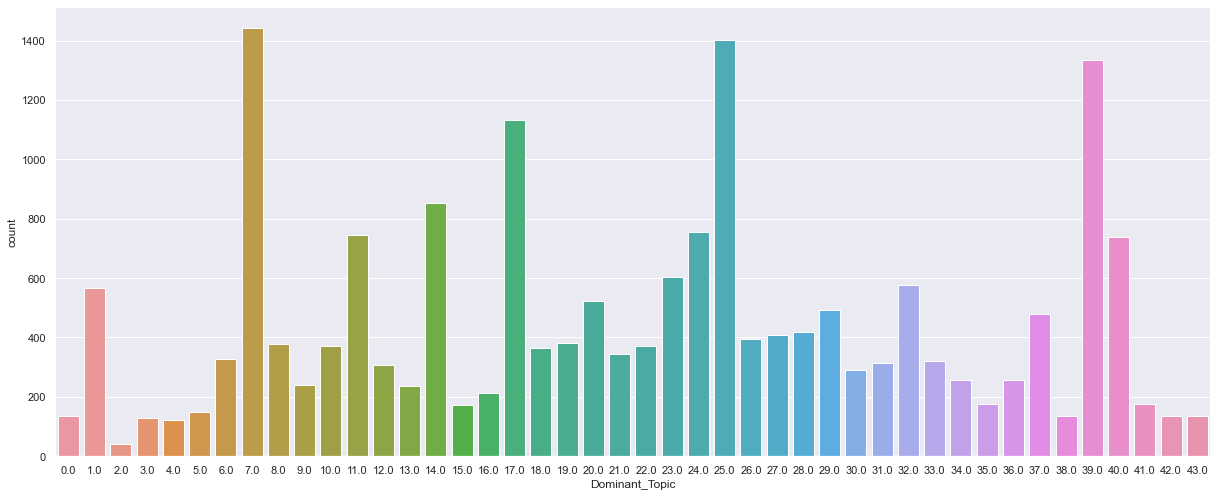

In [251]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.countplot(df_dominant_topic['Dominant_Topic'])

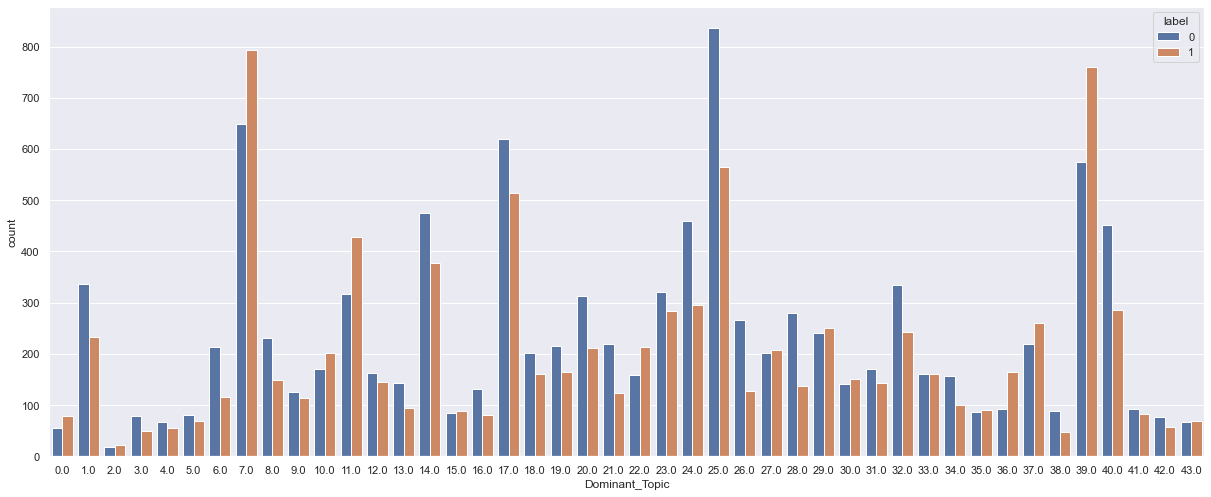

In [250]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.countplot(df_dominant_topic['Dominant_Topic'], hue= 'label', data= df_dominant_topic)